# **Activation Heatmaps**



So in this notebook, we will make a Class Activation Map (CAM) on an image. But first, What is a Class Activation Map?

take a look at the example:

![CAM Examples](https://raw.githubusercontent.com/anubhavmaity/Sports-Type-Classifier/master/readme_images/si_sports.png)

Class Activation Maps or **CAM**s are a great way to get the discriminative image regions used by a CNN (Convolutional Neural Network) to identify a specific class in an image. This is a useful technique for debugging and visualizing the contributing parts of the image to the model's prediction.

# **Getting started**

## **Import the libraries**

In [4]:
import cv2
import numpy as np
import pandas as pd
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import matplotlib.image as mimg

## **The image we will put the activation heatmap on**

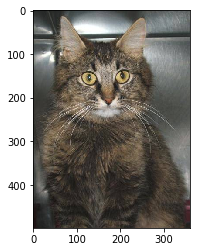

In [5]:
img_path = "data/cat.jpg"
img = mimg.imread(img_path)
plt.imshow(img)

## **Processing the image**

Now we will process the image by resizing it into a 224x224 image and then convert it into a numpy array

In [6]:
from keras.preprocessing import image

def process_image(input_img):
  img = image.load_img(input_img, target_size=(224, 224))
  np_arr = image.img_to_array(img)
  np_arr = np.expand_dims(np_arr, axis=0)
  np_arr = preprocess_input(np_arr)
  return np_arr

img = process_image(img_path)
img

array([[[[-6.0939003e+01, -7.2778999e+01, -8.1680000e+01],
         [-6.0939003e+01, -7.2778999e+01, -8.1680000e+01],
         [-6.1939003e+01, -7.3778999e+01, -8.2680000e+01],
         ...,
         [-2.9390030e+00, -1.4778999e+01, -2.5680000e+01],
         [-8.9390030e+00, -2.0778999e+01, -3.1680000e+01],
         [-9.9390030e+00, -2.1778999e+01, -3.2680000e+01]],

        [[-5.8939003e+01, -7.0778999e+01, -7.9680000e+01],
         [-5.9939003e+01, -7.1778999e+01, -8.0680000e+01],
         [-5.9939003e+01, -7.1778999e+01, -8.0680000e+01],
         ...,
         [-7.9390030e+00, -1.9778999e+01, -3.0680000e+01],
         [-1.9390030e+00, -1.3778999e+01, -2.4680000e+01],
         [-7.9390030e+00, -1.9778999e+01, -3.0680000e+01]],

        [[-5.6939003e+01, -6.8778999e+01, -7.7680000e+01],
         [-5.7939003e+01, -6.9778999e+01, -7.8680000e+01],
         [-5.8939003e+01, -7.0778999e+01, -7.9680000e+01],
         ...,
         [ 6.0997009e-02, -1.1778999e+01, -2.2680000e+01],
         [

In [7]:
img.shape

(1, 224, 224, 3)

## **Using the VGG16 model**

Now we will be using a pre-trained model called VGG16. It refers to a deep convolutional network for object recognition developed and trained by Oxford's renown Visual Geometry Group (VGG).

In [8]:
model = VGG16(weights='imagenet')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 64373286793e3c8b2b4e3219cbf3544b so we will re-download the data.
553467904/553467096 [==============================] - 205s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
____________________________________________

## **Predicting**

In [9]:
preds = model.predict(img)
print('Predictions: ', decode_predictions(preds, top=5)[0])


40960/35363 [==================================] - 0s 1us/step
Predictions:  [('n02123045', 'tabby', 0.5941193), ('n02123159', 'tiger_cat', 0.1729398), ('n02123394', 'Persian_cat', 0.09134702), ('n02124075', 'Egyptian_cat', 0.009300926), ('n03942813', 'ping-pong_ball', 0.008535986)]


In [10]:
np.argmax(preds[0])

281

In [11]:
predictions = pd.DataFrame(decode_predictions(preds)[0],columns=['col1','category','probability']).iloc[:,1:]
print('Prediction:',predictions.loc[0,'category'])

Prediction: tabby


FYI: Tabby is a type of cat that is in the image, So the prediction went well.

## **Setting up the Grad-CAM**

In [12]:
from keras import backend as K

def make_grad_cam(inputs):
  np_argmax = np.argmax(preds[0])
  output = model.output[:, np_argmax]
  
  # Get the last convolutional layer in our model
  last_conv_layer = model.get_layer('block5_conv3')
  
  # Get the gradients of the outputs
  gradients = K.gradients(output, last_conv_layer.output)[0]
  pooled_grads = K.mean(gradients, axis=(0, 1, 2))

  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([inputs])
  
  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  return heatmap

make_grad_cam(img)

array([[-8.95377343e-06, -4.92673780e-06,  3.63943536e-06,
         4.13738007e-06,  1.19685774e-06, -4.94822234e-06,
        -6.61500462e-06, -2.91819674e-07,  2.76080664e-06,
         2.47511775e-06,  1.07711389e-06, -4.99705720e-07,
        -1.65104223e-06,  7.24720280e-07],
       [-6.89032049e-06, -1.83948532e-06,  4.25494727e-06,
         7.48897492e-06,  5.02129797e-06,  1.21042353e-06,
         7.37788014e-07,  2.59067974e-06,  4.33170317e-06,
         5.42149292e-06,  1.53294332e-06, -2.13333033e-06,
        -1.51116433e-06, -5.21220159e-07],
       [-4.25146982e-06, -4.49014124e-08,  8.20694004e-06,
         1.23426635e-05,  1.23819264e-05,  9.10912604e-06,
         7.29299836e-06,  9.56347776e-06,  1.05710424e-05,
         8.26701398e-06,  2.03028276e-06, -2.11500401e-06,
        -1.24418932e-06,  1.08269205e-06],
       [-1.82258134e-06, -2.27133364e-06,  1.95268149e-06,
         7.40997029e-06,  1.14085487e-05,  9.82394886e-06,
         8.08730147e-06,  9.47947228e-06,  1.

## **Setting up the Heatmap**

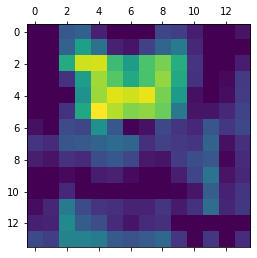

In [13]:
def gen_heatmaps(image_input):
  heatmap = make_grad_cam(image_input)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

generated_heatmap = gen_heatmaps(img)
plt.matshow(generated_heatmap)

Now, we've generated our heatmap congrats! You can see by the shape of the heatmap in the hottest region of the image, it resembles the cat's head shape. Now it's time to superimpose our heatmap with the original image. We will be using the `cv2` module to do the superimposition process of our heatmap to the original image.

## **Superimposing Our Heatmap**

Finished generating image!
Output: output/cat.jpg


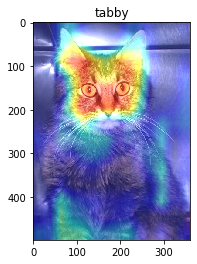

In [24]:
def superimpose_heatmap(image_input, hmap, intense_factor):
  img = cv2.imread(image_input)

  # Resizing the heatmap
  heatmap = cv2.resize(hmap, (img.shape[1], img.shape[0]))

  # Converting the heatmap values into rgb values
  heatmap = np.uint8(255 * heatmap)

  # Applying a colormap to the heatmap, which in this notebook we will use COLORMAP_JET
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * intense_factor + img

  # Saving the superimposed image
  output = 'output/cat.jpg'
  cv2.imwrite(output, superimposed_img)

  print("Finished generating image!")
  print("Output: " + output)

  plt.imshow(mimg.imread(output))
  plt.title(predictions.loc[0,'category'])

superimpose_heatmap(img_path, gen_heatmaps(img), 0.5)

And there you go. We've made our Class Activation Heatmap successfully! You can try it on other images aswell. Thank you!